### Example 1

In [9]:
import  cvxpy as cp

In [10]:
m, n = 20, 10
x = cp.Variable ((n, 1))
F = cp.Parameter ((m, n))
g = cp.Parameter ((m, 1))
lambd = cp.Parameter ((1, 1), nonneg=True)
objective_fn = cp.norm(F @ x - g) + lambd * cp.norm(x)
constraints = [x  >= 0]
problem = cp.Problem(cp.Minimize(objective_fn), constraints)
assert  problem.is_dpp ()

In [7]:
import  torch
from  cvxpylayers.torch  import  CvxpyLayer

In [11]:
F_t = torch.randn(m, n, requires_grad=True)
g_t = torch.randn(m, 1, requires_grad=True)
lambd_t = torch.rand(1, 1, requires_grad=True)
layer = CvxpyLayer(
    problem , parameters =[F, g, lambd], variables =[x])
x_star , = layer(F_t , g_t , lambd_t)
x_star.sum().backward ()

### Example 2

In [12]:
n, m = 2, 3
x = cp.Variable(n)
A = cp.Parameter((m, n))
b = cp.Parameter(m)
constraints = [x >= 0]
objective = cp.Minimize(0.5 * cp.pnorm(A @ x - b, p=1))
problem = cp.Problem(objective, constraints)
assert problem.is_dpp()

In [13]:
cvxpylayer = CvxpyLayer(problem, parameters=[A, b], variables=[x])
A_tch = torch.randn(m, n, requires_grad=True)
b_tch = torch.randn(m, requires_grad=True)

In [16]:
# solve the problem
solution, = cvxpylayer(A_tch, b_tch)
print(solution)

tensor([6.0573e-08, 7.6788e-01], grad_fn=<_CvxpyLayerFnFnBackward>)


In [30]:
# compute the gradient of the sum of the solution with respect to A, b
print(solution.sum().backward())

None


In [35]:
print(A_tch.grad)

tensor([[6.9450e-10, 1.1604e-08],
        [6.9450e-10, 2.2622e-08],
        [5.4907e-08, 6.9338e-01]])


### New Example

In [104]:
x = cp.Variable(1)
a = cp.Parameter(1)
c = cp.Parameter(1)
const = [x<=c]
objective = cp.Minimize(0.5*cp.norm(x-a))
problem = cp.Problem(objective, const)
assert problem.is_dpp()
print(problem.parameters())
cvxpylayer = CvxpyLayer(problem, parameters=[a, c], variables=[x])
a_tch = torch.randn(1, requires_grad=True)
c_tch = torch.randn(1, requires_grad=True)
# solve the problem
solution, = cvxpylayer(a_tch, c_tch)
print(solution)
# compute the gradient of the sum of the solution with respect to a, c
solution.sum().backward()
a_ = torch.linspace(-5,5,steps=1, requires_grad=True)
print(a)
#c.value = [2]
c_ = torch.tensor([3.0],requires_grad=True)
print(c)
y, = cvxpylayer(a_,c_)

[Parameter((1,)), Parameter((1,))]
tensor([-0.6935], grad_fn=<_CvxpyLayerFnFnBackward>)
param883
param884


In [2]:
import cvxpy as cp
import torch
from cvxpylayers.torch import CvxpyLayer

x = cp.Variable(pos=True)
y = cp.Variable(pos=True)
z = cp.Variable(pos=True)

a = cp.Parameter(pos=True, value=2.)
b = cp.Parameter(pos=True, value=1.)
c = cp.Parameter(value=0.5)

objective_fn = 1/(x*y*z)
objective = cp.Minimize(objective_fn)
constraints = [a*(x*y + x*z + y*z) <= b, x >= y**c]
problem = cp.Problem(objective, constraints)
assert problem.is_dgp(dpp=True)

layer = CvxpyLayer(problem, parameters=[a, b, c],
                   variables=[x, y, z], gp=True)
a_tch = torch.tensor(a.value, requires_grad=True)
b_tch = torch.tensor(b.value, requires_grad=True)
c_tch = torch.tensor(c.value, requires_grad=True)

x_star, y_star, z_star = layer(a_tch, b_tch, c_tch)
sum_of_solution = x_star + y_star + z_star
sum_of_solution.backward()

In [78]:
print(a_tch.grad)

tensor(-0.2990)


In [79]:
print(b_tch.grad)

tensor(0.5979)


### ReLU Example

Text(0, 0.5, '$f(x)$')

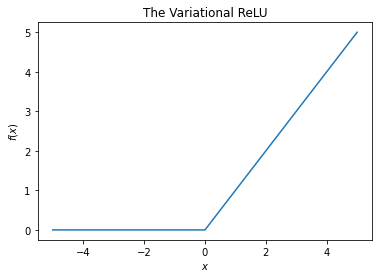

In [105]:
import matplotlib.pyplot as plt
n = 201
_x = cp.Parameter(n)
_y = cp.Variable(n)
obj = cp.Minimize(cp.sum_squares(_y-_x))
cons = [_y >= 0]
prob = cp.Problem(obj, cons)
layer = CvxpyLayer(prob, parameters=[_x], variables=[_y])
x = torch.linspace(-5, 5, steps=201, requires_grad=True)
# print(x)
y, = layer(x)
# print(y)
plt.plot(x.detach().numpy(), y.detach().numpy())
plt.title('The Variational ReLU')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

### Standard QP and gradient computation

In [7]:
import time
x = cp.Variable(1)
a = cp.Parameter(value=.5)
c = cp.Parameter(value=-2.)
const = [x<=c]
s = time.time()
objective = cp.Minimize(0.5*cp.norm(x-a))
problem = cp.Problem(objective, const)
assert problem.is_dpp()
print(problem.parameters())

cvxpylayer = CvxpyLayer(problem, parameters=[a, c], variables=[x])
a_tch = torch.tensor(a.value, requires_grad=True)
c_tch = torch.tensor(c.value, requires_grad=True)

# solve the problem
solution, = cvxpylayer(a_tch, c_tch)
print(solution.detach().numpy())
print(x.value)

# compute the gradient of the sum of the solution with respect to a, c
solution.sum().backward()
print(time.time()-s)
print("a grad ", a_tch.grad.numpy())
print("c grad ", c_tch.grad.numpy())
problem.solve()
print(problem.status)
print(x.value)


[Parameter(()), Parameter(())]
[-2.]
None
0.013217926025390625
a grad  -1.7444074e-13
c grad  1.0
optimal
[-2.]


In [119]:
# Correct!!!

In [6]:
import time
import numpy as np
x = cp.Variable((2,1))
a = cp.Parameter((2,1),value=np.array([[.5],[.5]]))
c = cp.Parameter((2,1),value=np.array([[-2],[-2]]))
const = [x<=c]
s = time.time()
objective = cp.Minimize(0.5*cp.norm(x-a))
problem = cp.Problem(objective, const)

assert problem.is_dpp()
print(problem.parameters())

cvxpylayer = CvxpyLayer(problem, parameters=[a, c], variables=[x])
a_tch = torch.tensor(a.value, requires_grad=True)
c_tch = torch.tensor(c.value, requires_grad=True)

# solve the problem
solution, = cvxpylayer(a_tch, c_tch)
print(solution.detach().numpy())
print(x.value)

# compute the gradient of the sum of the solution with respect to a, c
solution.sum().backward()
print(time.time()-s)
print("a grad ", a_tch.grad.numpy())
print("c grad ", c_tch.grad.numpy())
problem.solve()
print(problem.status)
print(x.value)

[Parameter((2, 1)), Parameter((2, 1))]


RuntimeError: Only Tensors of floating point and complex dtype can require gradients